# Replication - NAFLD

Here we provide a notebook to replicate the application to the nafld1 data set from R-Survival


The notebook replicates the results in:
- /out/application/nafld1/*

The main script can be found at: 
- /scripts/application/nafld.py
- /scripts/application/nafld.R

In [1]:
# google colab specific - installing probcox
!pip3 install probcox

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 614kB 3.7MB/s 
  Created wheel for probcox: filename=probcox-0.0.5-cp37-none-any.whl size=5226 sha256=fd1a7e4bf663662af0fd0125701e3f0b77aa5a0c5080f1e246418a9c4395eb7e
  Stored in directory: /root/.cache/pip/wheels/7a/ed/e5/71cb95c54c96702f1412114114806c74394f421b6cbda6af70
Successfully built probcox


In [2]:
# Modules
# =======================================================================================================================
import os
import sys
import shutil
import subprocess
import tqdm

import numpy as np
import pandas as pd

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor

np.random.seed(98345)
torch.manual_seed(7632)

In [3]:
# Loading Data
# =======================================================================================================================
url = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/data/application/nafld1.csv?token=AIVIKKA42MFTU4HSWM2BXWTATVKZG'
nafld = pd.read_csv(url, sep=',')

surv = np.asarray(nafld[['futime', 'status']])
surv = np.concatenate((np.zeros((surv.shape[0], 1)), surv), axis=1)
X = np.asarray(nafld.iloc[:, 3:])


surv = torch.from_numpy(surv).type(torch.FloatTensor)
X = torch.from_numpy(X).type(torch.FloatTensor)

total_obs = surv.shape[0]
batch_size = 256
total_events = torch.sum(surv[:, -1] == 1)
sampling_proportion = [total_obs, batch_size, total_events, None]

100%|██████████| 10000/10000 [01:39<00:00, 100.38it/s]


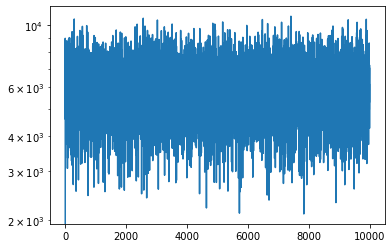

In [4]:
# Inference
# =======================================================================================================================

run = True
eta = 1.0
while run:
    run = False
    pyro.clear_param_store()
    m = pcox.PCox(sampling_proportion=sampling_proportion)
    m.initialize(eta=eta, num_particles=5)
    loss=[0]
    for ii in tqdm.tqdm(range((10000))):
        idx = np.random.choice(range(surv.shape[0]), batch_size, replace=False)
        data=[surv[idx], X[idx]]
        if torch.sum(data[0][:, -1]) > 0:
            loss.append(m.infer(data=data))
        if loss[-1] != loss[-1]:
            eta = eta * 0.5
            run=True
            break
    g = m.return_guide()
    out = g.quantiles([0.025, 0.5, 0.975])
plt.semilogy(loss)



In [5]:
# Prepare summary tables
# =======================================================================================================================
a = np.round(out['theta'][1].detach().numpy()[:, 0], 2)
b = np.round(torch.diag(pyro.get_param_store()['AutoMultivariateNormal.scale_tril']).detach().numpy(), 2)
c =np.sign(out['theta'][0].detach().numpy()) == np.sign(out['theta'][2].detach().numpy())
for ii in range(X.shape[1]):
    if c[ii]:
        sig = '*'
    else:
        sig = ''
    print(str(a[ii]) + sig + ', (' + str(b[ii]) + ')')

ci = pcox.metrics(surv=surv.numpy(), linpred=torch.mm(X, out['theta'][1].detach()).numpy(), processes=4).concordance()[None]
print(ci)

-0.13, (0.26)
-0.28*, (0.06)
0.2*, (0.05)
0.54*, (0.08)
1.47*, (0.05)
[0.82731533]


In [6]:
# load R 
%load_ext rpy2.ipython

In [7]:
# install packages
%%R 
install.packages('survival')

library(survival)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survival_3.2-11.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 6274168 bytes (6.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

In [8]:
%%R 
rm(list=ls())
library(survival)

data("nafld")
nafld1 = nafld1[complete.cases(nafld1),]

nafld1 = data.frame(c(nafld1['futime'], nafld1['status'], nafld1['bmi'], nafld1['height'], nafld1['weight'], nafld1['male'], nafld1['age']))

standardize <- function(x){
(x - mean(x))/sqrt(var(x))
}
names(nafld1)

nafld1[ , c(3, 4, 5, 7)] = apply(nafld1[ , c(3, 4, 5, 7)], 2, standardize)

m = coxph(Surv(futime, status) ~., data=nafld1)
summary(m)



Call:
coxph(formula = Surv(futime, status) ~ ., data = nafld1)

  n= 12562, number of events= 1012 

           coef exp(coef) se(coef)      z Pr(>|z|)    
bmi    -0.10310   0.90204  0.23626 -0.436   0.6626    
height -0.24652   0.78151  0.13853 -1.780   0.0751 .  
weight  0.24346   1.27566  0.27251  0.893   0.3716    
male    0.57035   1.76889  0.09191  6.206 5.44e-10 ***
age     1.45587   4.28821  0.04112 35.409  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

       exp(coef) exp(-coef) lower .95 upper .95
bmi       0.9020     1.1086    0.5677     1.433
height    0.7815     1.2796    0.5957     1.025
weight    1.2757     0.7839    0.7478     2.176
male      1.7689     0.5653    1.4773     2.118
age       4.2882     0.2332    3.9562     4.648

Concordance= 0.828  (se = 0.007 )
Likelihood ratio test= 1753  on 5 df,   p=<2e-16
Wald test            = 1486  on 5 df,   p=<2e-16
Score (logrank) test = 1726  on 5 df,   p=<2e-16

